# Protein conformation topology

Compute persistence homology over protein conformational changes. In particular, we look at the persistence homology of [calmodulin](https://en.wikipedia.org/wiki/Calmodulin) with changes between PDB files `1cfd` and `1cm1`.

In [1]:
!pip install -q git+https://github.com/azlawson/PersistenceCurves.git
!pip install -q biopython
!pip install -q scikit-tda

In [2]:
import os
import numpy as np
import persistencecurves as pc
import matplotlib.pyplot as plt

from Bio.PDB import PDBParser
from ripser import ripser
from persim import wasserstein
from matplotlib import animation, rc

Biopython parser

In [3]:
parser = PDBParser(PERMISSIVE=1, QUIET=True)

## Generate persistence curves

ChimeraX is first used (outside of this program) to generate PDB files showing the intermediate positions between `1cfd` and `1cm1`. We read these in and compute the persistence curves for each.

This loop is rather time-intensive. We can alternatively load the life curves (`lcs`) directly from the `\data` folder.

In [4]:
os.chdir('/content/drive/MyDrive/protein-conformation-topology/data/morph_1cfd_1cm1')

In [ ]:
lcs = np.empty((0, 300), int) # Use if computing H_0, H_1, and H_2

for i in range(1, 61):
    file = '1cfd_1cm1_' + '{0:02d}'.format(i) + '.pdb'
    structure = parser.get_structure(file, file)
    
    # Generate a list of the protein's atoms' R^3 coordinates
    coords = []
    for atom in structure.get_atoms():
        coords.append(list(atom.get_vector()))
    coords = np.array(coords)
    
    # Compute persistent homology
    if len(coords) > 1300:
        diagram = ripser(coords, maxdim=2, thresh=10, do_cocycles=False, n_perm=1300)['dgms']
    else:
        diagram = ripser(coords, maxdim=2, thresh=10, do_cocycles=False)['dgms']

    # Generate persistence curves from diagrams
    d_h0 = pc.Diagram(Dgm=diagram[0], globalmaxdeath=10, inf_policy='remove')
    d_h1 = pc.Diagram(Dgm=diagram[1], globalmaxdeath=10, inf_policy='remove')
    d_h2 = pc.Diagram(Dgm=diagram[2], globalmaxdeath=10, inf_policy='remove')

    # Generate life curves
    lc_h0 = d_h0.lifecurve(meshstart=0, meshstop=10, num_in_mesh=100)
    lc_h1 = d_h1.lifecurve(meshstart=0, meshstop=10, num_in_mesh=100)
    lc_h2 = d_h2.lifecurve(meshstart=0, meshstop=10, num_in_mesh=100)

    # Concatenate life curves for a particular conformation
    lc_all = np.concatenate((lc_h0, lc_h1, lc_h2))
    lcs = np.vstack((lcs, lc_all))

    # Monitor progress (uncomment)
    # print(lcs.shape)

In [ ]:
os.chdir('/content/drive/MyDrive/protein-conformation-topology/data')
np.save('lcs.npy', lcs)

## Load pre-computed persistence curves

In [5]:
os.chdir('/content/drive/MyDrive/protein-conformation-topology/data')
lcs = np.load('lcs.npy')

## Compute $L^2$ norm

Compute the $L^2$ norm between the persistence curve of the initial conformation, `1cfd`, and every other intermediate conformation through to `1cm1`.

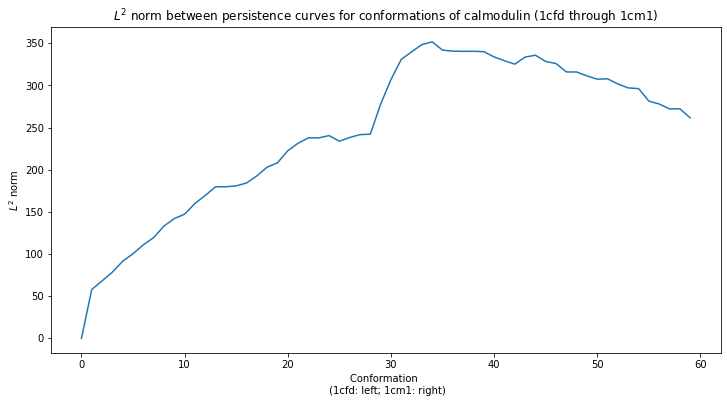

In [6]:
# Compute across H_0, H_1, and H_2
homology = range(000, 300)

dist = []
for k in range(60):
    dist.append(np.linalg.norm(lcs[0, homology] - lcs[k, homology]))

plt.subplots(figsize=(12, 6))
plt.title("$L^2$ norm between persistence curves for conformations of calmodulin (1cfd through 1cm1)")
plt.xlabel("Conformation \n (1cfd: left; 1cm1: right)")
plt.ylabel("$L^2$ norm")
plt.plot(dist)
plt.show()

Which conformation is maximally different from `1cfd`?

In [7]:
np.argmax(dist)

34

## Plot persistence curves

Plot all the persistence curves layered onto one another.


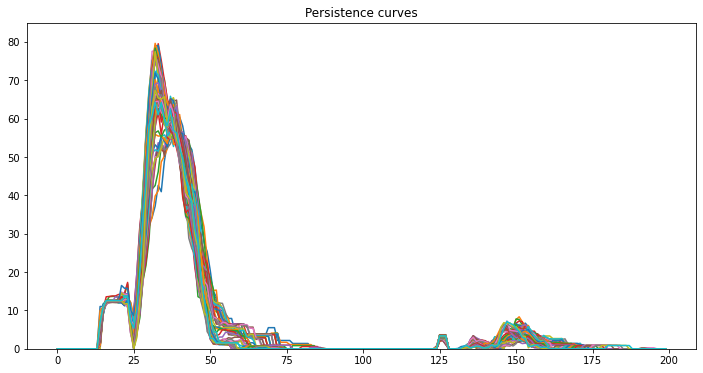

In [8]:
# Compute across H_1, and H_2
homology = range(100, 300)

fig, ax = plt.subplots(figsize=(12, 6))
for k in range(60):
    ax.plot(lcs[k, homology])
    ax.set_title('Persistence curves')
plt.ylim([0, 85])
plt.show()

Plot the persistence curves for `1cfd`, `1cm1`, and the maximally different (from `1cfd`) conformation.



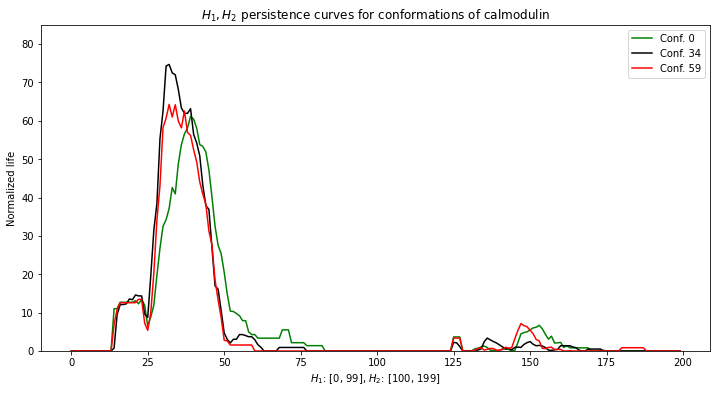

In [9]:
# Compute across H_1, and H_2
homology = range(100, 300)

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['green', 'black', 'red']
indices = [0, 34, 59]
for k in range(3):
    ax.plot(lcs[indices[k], homology], color=colors[k], label='Conf. '+str(indices[k]))
    ax.set_title('Persistence curves')
plt.ylim([0, 85])
plt.title("$H_1, H_2$ persistence curves for conformations of calmodulin")
plt.xlabel("$H_1$: [0, 99], $H_2$: [100, 199]")
plt.ylabel("Normalized life")
plt.legend(loc="upper right")
plt.show()

Create animated plot of the persistence curves for each conformation between `1cfd` and `1cm1`.

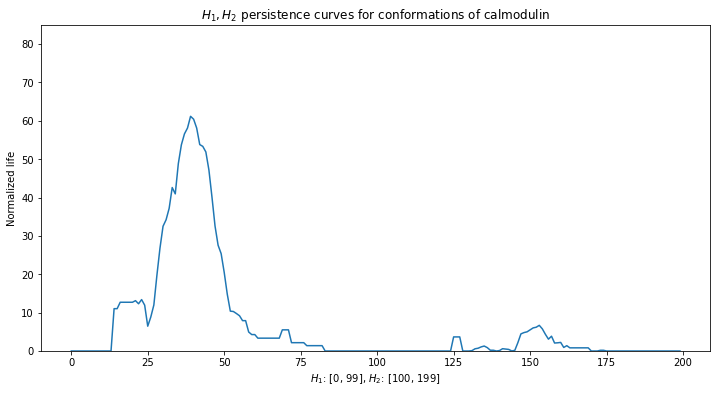

In [10]:
# Compute across H_1, and H_2
homology = range(100, 300)

fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot(lcs[0, homology])
plt.ylim([0, 85])
plt.title("$H_1, H_2$ persistence curves for conformations of calmodulin")
plt.xlabel("$H_1$: [0, 99], $H_2$: [100, 199]")
plt.ylabel("Normalized life")

def animate(i):
    line.set_ydata(lcs[i, homology])
    return line,

anim = animation.FuncAnimation(fig, animate, range(0, 60), interval=100)
rc('animation', html='jshtml')
anim

## Visualize Rips complexes

In [11]:
!pip install -q gudhi

In [12]:
import gudhi
import plotly

from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import graph_objs as go

In [13]:
os.chdir('/content/drive/MyDrive/protein-conformation-topology/data/morph_1cfd_1cm1')

Define function to configure Plotly for use in the browser.

In [14]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

Define function to generate Rips complex with a specified threshold filtration (`thresh`) and visualize it.

In [15]:
def plot_rips(i, thresh):
    file = '1cfd_1cm1_' + '{0:02d}'.format(i) + '.pdb'
    structure = parser.get_structure(file, file)

    # Generate a list of the protein's atoms' R^3 coordinates
    coords = []
    for atom in structure.get_atoms():
        coords.append(list(atom.get_vector()))
    coords = np.array(coords)

    # Generate Rips complex with GUDHI
    rc = gudhi.RipsComplex(points=coords, max_edge_length=thresh)
    st = rc.create_simplex_tree(max_dimension=2)

    # We are only going to plot the triangles
    triangles = np.array([s[0] for s in st.get_skeleton(2) if len(s[0])==3])
    triangles.shape

    # Need next two lines prior to each Plotly plot
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    # Generate figure
    fig = go.Figure(
        data=[
            go.Mesh3d(
                # Use the first 3 coordinates, but we could as easily pick others
                x=coords[:,0],
                y=coords[:,1],
                z=coords[:,2],
                i = triangles[:,0],
                j = triangles[:,1],
                k = triangles[:,2],
                intensity=coords[:,2], # z-axis
                colorscale='Viridis'
            )
        ]#,
        # layout = go.Layout(
        #     title = dict(
        #         text = 'Rips Complex Representation'
        #     )
        # )
    )

    fig.update_layout(
        font_family="Courier New",
        font_color="black",
        title_font_family="Times New Roman",
        title_font_color="red",
        legend_title_font_color="green",
        autosize=False,
        width=600,
        height=500,
        margin=dict(
            l=50,
            r=50,
            b=50,
            t=0,
            pad=5
        )
    )

    fig.update_traces(showscale=False)
    fig.show()

    # Export JSON file of Plotly figure for Hugo site
    from plotly.io import write_image
    fig.write_json("../rips_"+str(i-1)+".json")

### Create Rips complexes

Visualize Rips complexes for `1cfd`, `1cm1`, and the maximally different (from `1cfd`) conformation.

In [16]:
# Rips complexes for 1cfd
plot_rips(1, 4)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Rips complexes for maximally different conformation
plot_rips(35, 4)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Rips complexes for 1cm1
plot_rips(60, 4)

Output hidden; open in https://colab.research.google.com to view.